# YouTube Video Analysis
By: **John Pazzelli**  
January, 2018

### Q:  How does a video's metadata (e.g. title, description, tags, thumbnail) influence its view count?
## Abstract
This project sampled and analyzed about **30k YouTube videos** using the [Google Cloud YouTube Data API](https://developers.google.com/youtube/v3/getting-started) to determine if a video's metadata fields (**Title, Description, Tags, Duration, Category** and **Thumbnail Image**) can be used to **predict the popularity** of the video (i.e. the view count).  Thumbnail images were passed through the [Google Cloud Vision API](https://cloud.google.com/vision/docs/) and converted to a list of text labels.  All textual data was pre-processed using **text vectorization** and passed into a regression model using a **Linear Support Vector Regressor** (LinearSVR) in scikit-learn for a **peak $R^2$ (coefficient of determination) score of ~0.5**.

The **model was interpreted** by examining the **coefficients** assigned to each of the ~2500 features by the LinearSVR, consisting of the Duration and Category fields as well as the vocabulary fragments generated by the text vectorizers for each text field.  In this model, the **Duration field was assigned the largest positive coefficient** and was thus the **best baseline predictor** for video popularity.  Of the **top 100 model coefficients**, **58** corresponded to vocabulary fragments in the **Description** field whereas the **Tags and Title fields only had 19 and 20**, respectively.  The **Thumbnail Labels** generated by the Cloud Vision API were found to be the worst predictor of view counts with only **3 of the 100** top coefficients.

The vocabulary fragments that best predict high view counts for each of the metadata text fields are shown in the **[wordcloud of the top 80 vocabulary terms](https://github.com/JP-DataScienceProjects/YouTubeVideoAnalysis/blob/master/Screenshots/Wordcloud_combined.png)** with larger words representing better predictors of video popularity (note that word **stemming** was used so the words are frequently missing suffixes).

## Procedure
### Video Sampling
- I will be sampling YouTube video metadata using the **Google YouTube Data API**
- I am primarily interested in the **fields that a user can see before they click on a video**, particularly the **Title, Description, Tags, Video Duration and the Video Thumbnail**
- In order to use thumbnails in this analysis, I will also be using the **Google Cloud Vision API** to convert thumbnail images to text labels that can then be vectorized for machine learning

The code below is used to query the YouTube APIs to obtain videos using a search string (randomly selected from an input list of terms) or to obtain totally random videos.  Since YouTube doesn't have a built-in way of getting totally random videos, I am instead generating a random string of 4 characters using the video ID character set and searching / matching on the video ID field.  Using this data, **I will be attempting to predict each video's view count**:

In [5]:
%matplotlib inline

import sys
import random
import traceback
import binascii
import datetime
from datetime import datetime, timedelta, tzinfo
import dateutil
import pprint
from IPython.core.display import display, HTML, Image
from matplotlib import pyplot as plt
import re
import collections
from collections import deque
import configparser
import numpy as np
import pandas as pd
import nltk
from scipy import sparse
from apiclient.discovery import build

# Seed PRNG
random.seed(42)

In [6]:
# Regex to convert video duration in ISO8601 format into seconds
#dur_re = re.compile(r"P(\d+D)*T(\d+H)*(\d+M)*(\d+S)*", re.I)
service = None
def build_service(cfg_file='config.cfg'):
    # Read config params from config file
    config = configparser.RawConfigParser()
    config.read(cfg_file)
    api_key = config.get('Configuration', 'api_key')
    API_SERVICE_NAME = config.get('Configuration', 'service_name')
    API_VERSION = config.get('Configuration', 'service_version')
    
    # Build service object to query YouTube API
    return build(API_SERVICE_NAME, API_VERSION, developerKey=api_key)

###################### HELPER FUNCTIONS ########################
# Generates a random string of length str_len to be used to retrieve pseudo-random videos from YouTube
# Since this function returns a string using a (slightly modified) base64 encoding, 6 bits are required
# for each character requested 
def get_random_search_string(str_len=4):
    if (str_len <= 0): return None
    # 6 bits per character - the remaining logic is to round up to the nearest byte
    bytecount = int(((str_len * 6) - 1) / 8) + 1
    randbytes = bytearray(random.getrandbits(8) for _ in range(bytecount))
    # Convert to base64 and replace + and / characters to match YouTube video ID character set (for URL safety)
    return binascii.b2a_base64(randbytes).replace("+", "_").replace("/", "-")[:str_len]

# Converts duration from ISO8601 format into total number of seconds
def convert_duration_to_seconds(durstring):
    # Regex to convert video duration in ISO8601 format into seconds
    result = re.match(r"P(\d+D)*T(\d+H)*(\d+M)*(\d+S)*", durstring, re.I)
    #result = dur_re.match(durstring)
    if not result: return numpy.NaN
    days = 0 if result.group(1) is None else int(result.group(1)[:-1])
    hours = 0 if result.group(2) is None else int(result.group(2)[:-1])
    minutes = 0 if result.group(3) is None else int(result.group(3)[:-1])
    seconds = 0 if result.group(4) is None else int(result.group(4)[:-1])
    return (days * 86400) + (hours * 3600) + (minutes * 60) + seconds

# Helper function to remove keyword arguments that are not set
def remove_empty_kwargs(**kwargs):
    good_kwargs = {}
    if kwargs is not None:
        for key, value in kwargs.items():
            if value: good_kwargs[key] = value
    return good_kwargs
################## END HELPER FUNCTIONS ########################


################## YOUTUBE API FUNCTIONS #######################
# Performs a YouTube video search using the variable input keywords
def youtube_search_list_by_keyword(service, **kwargs):
    kwargs = remove_empty_kwargs(**kwargs)
    #print("Running search.list()...")
    return service.search().list(**kwargs).execute()

# Retrieve video metadata given search terms
def youtube_video_list_by_keyword(service, **kwargs):
    kwargs = remove_empty_kwargs(**kwargs)
    #print("Running videos.list()...")
    return service.videos().list(**kwargs).execute()

def youtube_video_categories_list(service, **kwargs):
    kwargs = remove_empty_kwargs(**kwargs)
    #print("Running videoCategories.list()...")
    return service.videoCategories().list(**kwargs).execute()


# Loads the list of video categories into a DataFrame for possible use later
def get_video_categories(service=None, regioncode='US'):
    if service is None: service = build_service()
    categories = youtube_video_categories_list(service, part='snippet', regionCode=regioncode)
    results = list(map(lambda category: {'id': category['id'], 'categoryName': category['snippet']['title']}, categories['items']))
    df = pd.DataFrame(results)
    df.set_index('id', inplace=True)
    print("Loaded {0} video categories".format(len(df)))
    return df

# Performs a search for YouTube video IDs using the input search string
# searchtype must be either 'id' or 'title' and the search string is matched against either of these, respectively
def get_video_ids_by_string(service, searchstring, searchtype='id', minAgeInDays=30, maxResults=50, maxPages=3, ordertype='relevance', language='en', regioncode='US'):
    videoIDs = []
    pageToken = None
    pagesLoaded = 0
    publishedBefore = (pandas.to_datetime('now').tz_localize('UTC') - datetime.timedelta(days=minAgeInDays)).isoformat()
    while True:
        response = youtube_search_list_by_keyword(service, part='id,snippet', publishedBefore=publishedBefore, maxResults=maxResults, q=searchstring, pageToken=pageToken, type='video', order=ordertype, relevanceLanguage=language, regionCode=regioncode)
        pagesLoaded += 1
        #pprint.pprint(response)

        # Extract the IDs where the string is found
        # YouTube also returns matches on other fields but I'm ignoring these to ensure the sample is truly random
        searchstring = searchstring.upper()
        if searchtype == 'id':
            ids = [vid['id']['videoId'] for vid in filter(lambda item: searchstring in item['id']['videoId'].upper(), response['items'])]
        elif searchtype == 'title':
            ids = [vid['id']['videoId'] for vid in filter(lambda item: searchstring in item['snippet']['title'].upper(), response['items'])]

        # Add the IDs to the growing list of video IDs
        videoIDs.extend(ids)
        #print("Found {0} video IDs on this page".format(len(ids)))
        if len(videoIDs) >= maxResults: break

        # Break if no more result pages to load for this search string
        if not 'nextPageToken' in response.keys() or pagesLoaded >= maxPages: break

        # Return next page, if this request is paginated
        pageToken = response['nextPageToken']
        #print("Moving to next page token: {0}".format(pageToken))
    return videoIDs

# Get a list of video IDs that match a random search string
# A short random string of characters is generated corresponding to the possible characters in YouTube video IDs
# (same as base64 but with + and / substituted for _ and - respectively)
# The search string is checked against the returned video IDs and if a match is found, the list of IDs are returned
# If no match is found (i.e. the search string matched other parts of the video metadata but not the ID), the function
# recurses and tries again.  A result is generally found within 1-2 calls so this function is not exceptionally expensive
def get_video_ids_by_random_string(service, count=10, ordertype='relevance', language='en', regioncode='US'):
    print("Loading {0} video IDs...".format(count))
    videoIDs = []
    totalcalls = 0
    while (len(videoIDs) < count):
        randstring = get_random_search_string()
        #print("randstring = {0}".format(randstring))
        
        ids = get_video_ids_by_string(service, randstring, maxResults=min(count, 50), maxPages=1)
        totalcalls += 1

        # Add the IDs to the growing list of video IDs
        if len(ids) + len(videoIDs) > count: ids = ids[:count - len(videoIDs)]
        videoIDs.extend(ids)
        if totalcalls % 5 == 0: print("IDs found: {0}, API calls made: {1}".format(len(videoIDs), totalcalls))

        # Break if we have reached the required # of IDs, or no more result pages to load for this random string
        if len(videoIDs) >= count: break
    return videoIDs

# Converts YouTube video metadata in the JSON response format into a Python dictionary
# The JSON hierarchy is flattened and some field conversion is performed (dates, video durations, etc) for use in a DataFrame
def convert_json_to_dict(json):
    result = {}
    result['id'] = json['id']
    for parentkey in ['contentDetails', 'snippet', 'statistics']:
        if parentkey not in json.keys(): continue
        for childkey in json[parentkey].keys():
            if childkey != 'thumbnails': result[childkey] = json[parentkey][childkey]
    
    # Clean-up and standardize fields
    result['title'] = json['snippet']['localized']['title'] if 'snippet' in json.keys() and 'localized' in json['snippet'] and 'title' in json['snippet']['localized'] else None
    result['description'] = json['snippet']['localized']['description'] if 'snippet' in json.keys() and 'localized' in json['snippet'] and 'description' in json['snippet']['localized'] else None
    result['thumbnailUrl'] = json['snippet']['thumbnails']['high']['url'] if 'snippet' in json.keys() and 'thumbnails' in json['snippet'].keys() and 'high' in json['snippet']['thumbnails'].keys() and 'url' in json['snippet']['thumbnails']['high'].keys() else None
    result['duration'] = convert_duration_to_seconds(result['duration']) if 'duration' in result.keys() else np.NaN
    result['publishedAt'] = dateutil.parser.parse(result['publishedAt']) if 'publishedAt' in result.keys() else None
    result['retrievedAt'] = pandas.to_datetime('now').tz_localize('UTC')
    result['videoAge'] = (result['retrievedAt'] - result['publishedAt']) / numpy.timedelta64(1, 'D')
    return result

def get_random_video_metadata_by_search_term(service, searchterm=None, videocount=10, maxperreq=50, queryorder='relevance'):
    print ("Starting retrieval of random video metadata for {0} videos...".format(videocount))
    
    # Get list of random video IDs
    if searchterm:
        print("Querying for {0} in title field...".format(searchterm))
        videoIds = get_video_ids_by_string(service, searchterm, searchtype='title', maxResults=min(videocount, 50), ordertype=queryorder)
    else:
        videoIds = get_video_ids_by_random_string(service, videocount, ordertype=queryorder)
    #videoIds = [u'aSFeeN-OSO8']
    #videoIds = [u'aSFeeN-OSO8', u'K6fscx-OSO8', u'hLyl-Gq29-s', u'Gq29-gnlQDE', u'Gq29-YdZIbY', u'5IsW-5PKCBQ', u'5IsW-rkgUOQ', u'Xx9ruI-l2wI', u'OJiO8n-l2wI', u'8LHPml-l2wI', u'l2wI-fj5-Po', u'55TAE9-l2wI', u'O1HDQY-l2wI', u'l2wI-CxJbeg', u'O4Ga-0LLxOo', u'O4Ga-zGbebM', u't6az-mXkXtM', u't6az-YSD3X0', u't6az-EZBLxM', u'BCxTSq-i2s4', u'ueSe7a-i2s4', u'Oz4giN-i2s4', u'cdirXH-i2s4', u'omKRwf-i2s4', u'i2s4-14b_HE', u'9PBRIf-i2s4', u'B8r1HV-i2s4', u'syd65h-i2s4', u'wWict4-i2s4', u'rnCe7B-i2s4', u'cpZH-al0UJg', u'cpZH-YrKXFg', u'z94B-32_v2U', u'z94B-hpU7zw', u'z94B-dexMSw', u'OtiXWZ-ws4o', u'fT-U85-ws4o', u'ws4o-Ww0uyI', u'_J-ws4o-Iss', u'hs5iZa-ws4o', u'ws4o-KCz5qU', u'JJISAM-ws4o', u'DEcdjv-ws4o', u'1MAY71-ws4o', u'YyIzqo-ws4o', u'8DaApf-ws4o', u'ws4o-pmlP4s', u'ws4o-1y9oog', u'9cNW-YToIIU', u'9cNW-IEvbrg', u'C86ri8-GFvY', u'7PpJ2P-GFvY', u'WJpD-2-12Lw', u'zgu6-6egbzo', u'dYkf-vFKSfI', u'-FI1L-zjGe4', u'FI1L-Ckq4nc', u'1KCe-aPJnPY', u'4txc-6_-h70', u'4txc-l0BeZs', u'HYAwHD-4txc', u'gFq0SY-4txc', u'dJEsbr-4txc', u'4txc-1VsLrw', u'arX6pi-4txc', u'4txc-rgMoH0', u'lPQa2O-4txc', u'ObhFsR-kzG0', u'FK-sKu-kzG0', u'DVW5Ow-kzG0', u'Sdya77-kzG0', u'Sv5-O90ZdpQ', u'O90Z--tda78', u'O90Z-bsg3-I', u'O8DVxj-YUd0', u'NlrsVq-YUd0', u'YUd0-atBijY', u'5OEb6F-YUd0', u'F2gSKo-YUd0', u'V6t7i6-YUd0', u'YUd0-_NtJkQ', u'otVd-5aez1U', u'otVd-GBNVII', u'pRKb-FZSTHg', u'pRKb-H4xzAs', u'oiuI-w-BxDs', u'PkMPCt-oiuI', u'uj4p-QGGSeQ', u'feo8Yn-sI44', u'r1PX-DSiSis', u'r1PX-cedGPM', u'xMYO-UHdY34', u'zlBm-FywKcQ', u'6fGR-iHjry8', u'PWjn1X-4LdQ', u'L0pf69-4LdQ', u'qsndhE-4LdQ', u'vL2mRw-4LdQ', u'q9T0Ov-4LdQ']
    if len(videoIds) > videocount: videoIds = videoIds[:videocount]
    print("Video ID retrieval complete.  {0} total IDs found".format(len(videoIds)))
    #print(videoIds)
    
    # Retrieve metadata for each video from its ID
    # Slice the requests for video IDs into chunks of size maxperreq
    totalreqs = int((len(videoIds) - 1) / maxperreq) + 1
    metadata = collections.deque()
    for i in range(totalreqs):
        if (i+1) % 5 == 0: print ("Sending metadata request {0} of {1} for up to {2} video IDs...".format((i+1), totalreqs, maxperreq))
        
        ids = ",".join(videoIds[i*maxperreq:(i+1)*maxperreq])
        response = youtube_video_list_by_keyword(service, 
          part='id,snippet,contentDetails,statistics',
          fields='items(id,snippet(publishedAt,channelId,localized(title,description),thumbnails(high),tags,categoryId),contentDetails(duration),statistics(viewCount,likeCount,dislikeCount,commentCount))',
          hl='en-US',                                                 
          id=ids)

        # Convert each item in the json response to a format suitable for a pandas DataFrame
        metadata.extend(map(lambda item: convert_json_to_dict(item), response['items']))
        if (i+1) % 5 == 0: print("Total metadata returned: {0}, API calls made: {1}".format(len(metadata), (i+1)))
    
    # Convert the results into a DataFrame
    df = pandas.DataFrame(list(metadata))
    df.set_index('id', inplace=True)
    df = df[['title', 'description', 'categoryId', 'duration', 'tags', 'publishedAt', 'retrievedAt', 'videoAge', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'thumbnailUrl', 'channelId']]
    df['thumbnailLabels'] = None
    df = df.astype({'title': str, 'description': str, 'duration': float, 'viewCount': float, 'commentCount': float, 'likeCount': float, 'dislikeCount': float}, Copy=False)
    print("All metadata retrieved for {0} videos".format(len(videoIds)))
    return df

def get_random_video_metadata(totalvideostoretrieve, searchterms=None, videospersearchterm=20, queryorder='viewCount', maxexceptions=5, n_jobs=3):
    # Retrieve more videos using the word set from the previously-retrieve video titles
    df_newvideos = None
    exceptioncount = 0
    try:
        service = build_service()
        job_server = pp.Server(ncpus=n_jobs)
        job_queue = deque()
        while True:
            try:
                if exceptioncount >= maxexceptions:
                    print("Max exception count reached: {0}.  Aborting...".format(exceptioncount))
                    break

                # Get random videos from YouTube in blocks using a random search term for each one
                #print("Finding videos with '{0}' in the title...".format(randomword))
                videostoretrieve = min(videospersearchterm, totalvideostoretrieve - (0 if df_newvideos is None else len(df_newvideos)))
                while len(job_queue) <= n_jobs:
                    #df_newvids = get_random_video_metadata_by_search_term(searchterm=None, videocount=videostoretrieve, queryorder='viewCount')
                    if searchterms: randomword = searchterms[random.randint(0, len(searchterms))]
                    else: randomword = None
                    job_queue.appendleft(job_server.submit(get_random_video_metadata_by_search_term, (service, randomword, videostoretrieve, 50, queryorder), (get_video_ids_by_random_string, get_random_search_string,get_video_ids_by_string,youtube_search_list_by_keyword,remove_empty_kwargs,youtube_video_list_by_keyword,convert_json_to_dict,convert_duration_to_seconds), ("random",'binascii','pandas','datetime','collections','re','numpy','dateutil')))

                task = job_queue.pop()
                task()
                if type(task.result) is pd.DataFrame:
                    if df_newvideos is None: df_newvideos = task.result
                    else: df_newvideos = df_newvideos.append(task.result)

                    if len(df_newvideos) > totalvideostoretrieve: df_newvideos = df_newvideos.iloc[:totalvideostoretrieve]
                    print("Found {0} of {1} videos".format(len(df_newvideos), totalvideostoretrieve))
                    if len(df_newvideos) >= totalvideostoretrieve: break
                    exceptioncount = 0
                else:
                    print("Video metadata retrieval result was not a DataFrame.  Instead received: {0}".format(type(task.result)))
                    exceptioncount += 1
            except (KeyboardInterrupt, SystemExit):
                raise
            #except google.gax.errors.RetryError as err:
                #print ("Retry error caught: {0}\r\n{1}".format(type(err), err.args))
            except:
                print ("Unexpected error: {0}".format(sys.exc_info()[0]))
                traceback.print_exc()
                exceptioncount += 1
    finally:
        job_server.destroy()
        return df_newvideos

### Process Thumbnail Images
- I will use the **Google Cloud Vision API** to convert the thumbnail images for each video into a set of annotated labels for the learning algorithms:

In [7]:
# Code to return labels from a web image URI using the Google Cloud Vision API
import pp
import google
#from google.gax.errors import RetryError

# Detects labels in the file located in Google Cloud Storage or on the Web.
def detect_labels_uri(uri):
    if uri is None or len(uri) <= 0: return None
    
    # Init vision client and set the image URL to the input uri
    client = google.cloud.vision.ImageAnnotatorClient()
    image = google.cloud.vision.types.Image()
    image.source.image_uri = uri

    # Retrieve the JSON response from Google Cloud Vision API
    response = client.label_detection(image=image)
    labels = {}
    for label in response.label_annotations:
        labels[label.description] = label.score
    return labels


# Retrieve thumbnails for rows that are missing thumbnails
# This function is used for graceful recovery in case retrieval for all labels at once encounters an error
# Note that the time savings by vectorizing this is minimal since the I/O blocking accounts for nearly all of 
# the processing time so I opted to use a for loop to be able to write debugging info as progress is being made
def get_thumbnail_labels(df, maxrowstoload=30, resetlabels=False, n_jobs=3):
    if resetlabels or not 'thumbnailLabels' in df.columns: df['thumbnailLabels'] = None
    df_rowstofill = df[df.thumbnailLabels.isnull()]
    maxrows = min(len(df_rowstofill), maxrowstoload)
    if maxrows <= 0: return
    print ("Starting thumbnail label retrieval for {0} thumbnails...".format(maxrows))
    job_server = pp.Server(ncpus=n_jobs)
    job_dict = {}
    try:
        df_rowstofill = df_rowstofill[:maxrows]
        for key in df_rowstofill.index:
            uri = df_rowstofill.loc[key, 'thumbnailUrl']
            #print("uri type = {0}".format(type(uri)))
            if isinstance(uri, pd.Series): uri = uri.iloc[0]
            job_dict[key] = job_server.submit(detect_labels_uri, (uri,), (), ("google.cloud.vision",))

        for key in df_rowstofill.index:
            job_dict[key]()
            if job_dict[key].result is None: raise ValueError("Thumbnail tag retrieval failed!")
            #df.set_value(key, 'thumbnailLabels', job_dict[key].result)
            df.at[key, 'thumbnailLabels'] = job_dict[key].result
            
        print ("{0} total thumbnail labels retrieved".format(maxrows))
    finally:
        job_server.destroy()

#print(detect_labels_uri("https://i.ytimg.com/vi/n2iqzw-Oxwg/mqdefault.jpg"))

In [8]:
def fill_thumbnail_labels(df, maxexceptions=5, n_jobs=3):
    # Call get_thumbnail_labels in a loop with recovery logic to workaround intermittent RetryError exceptions
    # raised by Google Cloud API.  The function also operates only on small chunks of thumbnails so that partial
    # results can be saved in case an exception is raised and the code needs to be re-run
    ### This took about 6.5 hours to retrieve all thumbnail labels for 20k videos
    exceptioncount = 0
    while True:
        try:
            if exceptioncount >= maxexceptions:
                print("Max exceptions exceeded: {0}.  Aborting...".format(exceptioncount))
                break
            
            rowstofill = len(df[df.thumbnailLabels.isnull()])
            if rowstofill <= 0: break
            print("Found {0} total thumbnail images to label".format(rowstofill))

            get_thumbnail_labels(df, maxrowstoload=n_jobs*20, n_jobs=n_jobs)
            exceptioncount = 0
        except (KeyboardInterrupt, SystemExit):
            raise
        #except google.gax.errors.RetryError as err:
            #print ("Retry error caught: {0}\r\n{1}".format(type(err), err.args))
        except:
            print ("Unexpected error: {0}".format(sys.exc_info()[0]))
            traceback.print_exc()
            exceptioncount += 1
    return df

def get_webtext_words():
    import re
    from nltk.corpus import webtext, stopwords

    stop = stopwords.words('english')
    corpus = " ".join(list(webtext.words()))
    matches = re.findall(r'\b([A-Za-z]{3,})\b', corpus)
    wordset = sorted(set([w for w in matches if w not in stop]))
    return wordset
            
def get_youtube_dataset(size=20000, searchstringmethod='random',  videoordering='viewCount',  n_jobs=3, random_state=1):
    random.seed(random_state)
    
    # If retrieving purely random videos, limit the videos per random search string to 10 (this is to
    # limit the number of paging requests that are required to find 10 videos for the random query string)
    # Otherwise, search by a random word from the NLTK webtext corpus
    searchterms = None
    if searchstringmethod != 'random': searchterms = get_webtext_words()
    
    df_vids = None
    try:
        df_vids = get_random_video_metadata(size, searchterms, queryorder=videoordering, n_jobs=n_jobs)
        fill_thumbnail_labels(df_vids, n_jobs=n_jobs)
    finally:
        return df_vids

## Data Gathering

In [66]:
# Retrieve video categories
df_categories = get_video_categories()
df_categories.head()

Loaded 32 video categories


,categoryName
id,
1,Film & Animation
2,Autos & Vehicles
10,Music
15,Pets & Animals
17,Sports


In [26]:
# Retrieve 10k videos using random search words taking the top viewed videos for each term
#df_videos_orig = get_youtube_dataset(10000, searchstringmethod='dictionary', videoordering='viewCount', n_jobs=4, random_state=12)

In [158]:
# Look at the view count distribution for the 10k videos retrieved so far
df_videos_orig.describe()

,duration,videoAge,viewCount,likeCount,dislikeCount,commentCount
count,10000.000000,10000.000000,1.000000e+04,9.844000e+03,9.844000e+03,9704.000000
mean,503.929700,1513.082088,2.013347e+07,9.494610e+04,6.559198e+03,7684.721249
std,1095.991553,1078.122060,1.088891e+08,4.122655e+05,3.900054e+04,31153.128776
min,0.000000,30.006586,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,181.000000,598.943585,3.789460e+05,1.617500e+03,8.675000e+01,183.750000
50%,258.000000,1260.278513,2.369918e+06,1.283650e+04,7.295000e+02,1212.000000
75%,455.000000,2294.809896,1.109679e+07,6.150125e+04,3.175500e+03,5141.250000
max,36001.000000,4498.407905,3.015451e+09,1.456364e+07,1.189660e+06,823590.000000


- The videos at **25% IQR have nearly 400k views** so the **videos with high view counts are oversampled** in this distribution
- Next step is to **download another 10k videos using a random search string** (instead of dictionary words from the webtext corpus) in order to retrieve less popular videos so the distribution can be balanced out

In [168]:
# Retrieve 10k more videos without specifying search terms (they will be randomly generated)
#df_videos_random_orig = get_youtube_dataset(10000, n_jobs=3, random_state=15)

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 20, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 20 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 19, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 40 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 60 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 20, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 80 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 840 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 860 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 880 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 900 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 920 of 10000 videos
Starting retrie

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1660 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1680 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1700 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1720 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1740 of 10000 videos
Starting r

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2480 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2500 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2520 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 16, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2540 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Foun

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3260 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3280 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3300 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3320 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3340 of 10000 videos
Starting r

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 16, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4100 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4120 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 20, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4140 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4160 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All meta

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4940 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4960 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4980 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 20, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5000 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Foun

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5740 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5760 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5780 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5800 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5820 of 10000 videos
Starting r

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 6580 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 6600 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 6620 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 6640 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 20, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Foun

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7400 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7420 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7440 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7460 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7480 of 10000 videos
Starting r

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8240 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 20, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8260 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8280 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 20, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8300 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All meta

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9060 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9080 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9100 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9120 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9140 of 10000 videos
Starting r

Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9900 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9920 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
IDs found: 20, API calls made: 5
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9940 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9960 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Loading 20 video IDs...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Foun

60 total thumbnail labels retrieved
Found 6877 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 6817 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 6757 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 6697 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 6637 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 6577 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 6517 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 6457 total th

60 total thumbnail labels retrieved
Found 3195 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 3135 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 3075 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 3015 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 2955 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 2895 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 2835 total thumbnail images to label
Starting thumbnail label retrieval for 60 thumbnails...
60 total thumbnail labels retrieved
Found 2775 total th

- I found through later analysis that **using purely random strings** to retrieve videos **resulted in a lot of non-English videos** being returned and since I will be trying to filter these out, a lot of this data will be dropped
- I will therefore **get 10k more videos** (30k total so far) by searching using the webtext corpus of **English words** but **ordering the results by date** instead of view count so that more English videos with low-mid view counts will be added to the sampling

In [111]:
# Retrieve 10k more videos using dictionary search terms and ordering by date published (I expect lower view count videos to be returned)
df_videos_random = get_youtube_dataset(10000, searchstringmethod='dictionary', videoordering='date', n_jobs=4, random_state=21)

Starting retrieval of random video metadata for 20 videos...
Querying for Jamie in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 20 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for marines in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 40 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for inccorrect in title field...
Video ID retrieval complete.  5 total IDs found
All metadata retrieved for 5 videos
Found 45 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for cowering in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 65 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Nicaragua in title field...
Video ID retrieval complete.  20 total IDs found
All m

Starting retrieval of random video metadata for 20 videos...
Querying for prawns in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 787 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Move in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 807 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for version in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 827 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for steel in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 847 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for pas in title field...
Video ID retrieval complete.  20 total IDs found
All metadata 

Starting retrieval of random video metadata for 20 videos...
Querying for worse in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1207 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for decoration in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1227 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for dangling in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1247 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for expand in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1267 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for owned in title field...
Video ID retrieval complete.  20 total IDs found


Starting retrieval of random video metadata for 20 videos...
Querying for sale in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1958 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Causes in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1978 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Rebecca in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 1998 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Smurfette in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2018 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for brewed in title field...
Video ID retrieval complete.  20 total IDs found
Al

Starting retrieval of random video metadata for 20 videos...
Querying for BCC in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2545 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for glop in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2565 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for institution in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2585 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for servant in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 2605 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for functionality in title field...
Video ID retrieval complete.  20 total IDs fo

Starting retrieval of random video metadata for 20 videos...
Querying for complaining in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3185 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Collins in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3205 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for pgp in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3225 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for LIKE in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3245 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for mousewheel in title field...
Video ID retrieval complete.  10 total IDs found

Starting retrieval of random video metadata for 20 videos...
Querying for feature in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3594 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Color in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3614 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for remarks in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3634 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for warheads in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 3654 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for accepts in title field...
Video ID retrieval complete.  20 total IDs found


Starting retrieval of random video metadata for 20 videos...
Querying for Dimitri in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4234 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for cracked in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4254 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for darker in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4274 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for namechange in title field...
Video ID retrieval complete.  1 total IDs found
All metadata retrieved for 1 videos
Found 4275 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for stalker in title field...
Video ID retrieval complete.  20 total IDs found

Found 4735 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for communist in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 4755 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for FFox in title field...
Video ID retrieval complete.  0 total IDs found
An error has occured during the function execution
Traceback (most recent call last):
  File "c:\users\john\appdata\local\programs\python\lib\site-packages\ppworker.py", line 90, in run
    __result = __f(*__args)
  File "<string>", line 36, in get_random_video_metadata_by_search_term
  File "C:\Users\John\AppData\Roaming\Python\Python27\site-packages\pandas\core\frame.py", line 2830, in set_index
    level = frame[col]._values
  File "C:\Users\John\AppData\Roaming\Python\Python27\site-packages\pandas\core\frame.py", line 1964, in __getitem__
    return self._getitem_column(key)
  File "C:\Users\John\AppDa

Starting retrieval of random video metadata for 20 videos...
Querying for hipsters in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5139 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Semitic in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5159 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Krazy in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5179 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for attract in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5199 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for SUBSTANCE in title field...
Video ID retrieval complete.  20 total IDs foun

Starting retrieval of random video metadata for 20 videos...
Querying for specified in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5839 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Around in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5859 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for front in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5879 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Decreasing in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 5899 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for strike in title field...
Video ID retrieval complete.  20 total IDs foun

Starting retrieval of random video metadata for 20 videos...
Querying for Damned in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 6585 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for ricochets in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 6605 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Navigating in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 6625 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Britain in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 6645 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Zip in title field...
Video ID retrieval complete.  20 total IDs found

Starting retrieval of random video metadata for 20 videos...
Querying for tin in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7168 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for embed in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7188 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for spaces in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7208 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for More in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7228 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for younger in title field...
Video ID retrieval complete.  20 total IDs found
All metad

Starting retrieval of random video metadata for 20 videos...
Querying for injury in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7768 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for plants in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7788 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for pancetta in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7808 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for irreparable in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 7828 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Queer in title field...
Video ID retrieval complete.  20 total IDs foun

Starting retrieval of random video metadata for 20 videos...
Querying for yes in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8187 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Maury in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8207 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for PARTNER in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8227 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for oar in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8247 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for rejected in title field...
Video ID retrieval complete.  20 total IDs found
All meta

Starting retrieval of random video metadata for 20 videos...
Querying for Visiting in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8944 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for invasion in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8964 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for altered in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 8984 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Mama in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9004 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Hallelujah in title field...
Video ID retrieval complete.  20 total IDs fou

Starting retrieval of random video metadata for 20 videos...
Querying for Nevins in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9670 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Cain in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9690 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Lonny in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9710 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for Hungarian in title field...
Video ID retrieval complete.  20 total IDs found
All metadata retrieved for 20 videos
Found 9730 of 10000 videos
Starting retrieval of random video metadata for 20 videos...
Querying for houses in title field...
Video ID retrieval complete.  11 total IDs found
All 

In [113]:
# Combine the 10k high view count videos and 10k random video sample into a single Dataframe
df_allvideos_orig = df_videos_orig.append(df_videos_random_orig).append(df_videos_random)

In [114]:
## UNCOMMENT TO REWRITE THESE EXPENSIVE DATAFRAMES TO THE CACHE
#%store df_categories
#%store df_allvideos_orig
#%store df_videos_orig
#%store df_videos_random_orig
#%store df_videos_random

Stored 'df_categories' (DataFrame)
Stored 'df_allvideos_orig' (DataFrame)
Stored 'df_videos_orig' (DataFrame)
Stored 'df_videos_random_orig' (DataFrame)
Stored 'df_videos_random' (DataFrame)


In [96]:
# Use to restore saved DataFrames from disk
%store -r df_categories
%store -r df_allvideos_orig
%store -r df_videos_orig
%store -r df_videos_random_orig
%store -r df_videos_random

no stored variable df_allvideos_orig
no stored variable df_videos_orig
no stored variable df_videos_random_orig
no stored variable df_videos_random


## Data Cleansing
- Check for duplicate video IDs (possible since same video could be retrieved using different search terms)

In [115]:
# Locate duplicate videos by video ID using a Counter
counts = collections.Counter(df_allvideos_orig.index)
duplicates = []
for i,val in enumerate(counts.values()):
    if val > 1:
        # Track duplicate video ID keys and print any with more than 2 occurrences
        duplicates.append(counts.keys()[i])
        if val > 2: print(counts.keys()[i], val)

print ("Total duplicates found: {0}".format(len(duplicates)))
#print(df_allvideos_orig.loc[duplicates[0]])

(u'Xn3tUOJ9yv4', 3)
(u'RYnFIRc0k6E', 3)
(u'MVU-EqPcUjU', 3)
(u'us0qySiUsGU', 3)
(u'e3-3cyMc4CY', 3)
Total duplicates found: 460


- **Join the video category text** to the dataset (just for human readability)
- **Drop duplicate rows**

In [124]:
# Join the video category names to the main metadata DataFrame
df_merged = pd.merge(df_allvideos_orig, df_categories, how='left', left_on=['categoryId'], right_index=True)

# Drop duplicates rows, result is right around what we expect (30,000 - 460 = 29540)
df_allvideos_unique = df_merged.drop_duplicates(subset=['title', 'description', 'categoryId', 'duration', 'publishedAt'], keep='first')
print(len(df_allvideos_unique))

29524


In [221]:
# Have a look at the data - not all fields will be used for learning
df_allvideos_unique.head()

,title,description,categoryId,duration,tags,publishedAt,retrievedAt,videoAge,viewCount,likeCount,dislikeCount,commentCount,thumbnailUrl,channelId,thumbnailLabels,categoryName
id,,,,,,,,,,,,,,,,
LgQJ-upUXhY,Shining Shoes,Provided to YouTube by DistroKid\n\nShining Sh...,10,272,"[Brutofuzz, Italian, Breakfast, Shining, Shoes]",2017-09-30 10:20:57+00:00,2018-01-10 22:28:24+00:00,102.505174,0,0,0,0,https://i.ytimg.com/vi/LgQJ-upUXhY/hqdefault.jpg,UCYKy1dz34T6uIGYbWuEck7Q,"{'font': 0.5287910103797913, 'product': 0.7113...",Music
JM1OW4-6Kq0,Learn Colors with Minions Banana Song Gunter f...,,22,244,"[3D CARTOON BABY, learn colors with surprise e...",2017-06-10 19:35:03+00:00,2018-01-10 22:26:22+00:00,214.118970,0,0,0,0,https://i.ytimg.com/vi/JM1OW4-6Kq0/hqdefault.jpg,UCwsIAJqMj2Akl5yF_UljREA,"{'pink': 0.9514991044998169, 'purple': 0.85528...",People & Blogs
kT6pUpJkmZI,track mobile number location in Nicaragua [ te...,welcome to newsoftech channel. we daily upload...,25,61,[],2017-09-21 15:04:49+00:00,2018-01-12 15:01:46+00:00,112.997882,0,0,0,0,https://i.ytimg.com/vi/kT6pUpJkmZI/hqdefault.jpg,UChCRwb34gB1cPhXKDKPJVkQ,"{'font': 0.8387523293495178, 'screenshot': 0.7...",News & Politics
z3DsnFsCVe8,Kasabian - You're In Love With A Psycho Live @...,,20,0,[],2017-12-05 21:32:37+00:00,2018-01-12 15:01:46+00:00,37.728576,0,0,0,0,https://i.ytimg.com/vi/z3DsnFsCVe8/hqdefault_l...,UCLDodm_N1EzkQugq2FOE4OA,"{'product': 0.5977660417556763, 'text': 0.8650...",Gaming
lIgwM_-6kQ0,day07 06 树的组件的开发 1 - OA办公自动化-赵栋OA - java项目,源码与资料：http://pan.baidu.com/s/1kURldyR\n\n\n教学视...,28,792,[],2017-07-23 17:06:11+00:00,2018-01-10 22:26:22+00:00,171.222350,0,0,0,0,https://i.ytimg.com/vi/lIgwM_-6kQ0/hqdefault.jpg,UCt71csbT4t_6mVqIClG_HzA,"{'blue': 0.9681809544563293, 'product': 0.7517...",Science & Technology


- **Remove empty / null values** for the important fields (duration, view count, thumbnail labels) and fill in some others

In [222]:
# Remove videos with no viewCount value and fill in some empties
df_allvideos_unique = df_allvideos_unique[~df_allvideos_unique.duration.isnull()]
df_allvideos_unique = df_allvideos_unique[~df_allvideos_unique.viewCount.isnull()]
df_allvideos_unique = df_allvideos_unique[~df_allvideos_unique.thumbnailLabels.isnull()]
df_allvideos_unique = df_allvideos_unique[df_allvideos_unique.videoAge >= 30]

df_allvideos_unique.likeCount.fillna(0, inplace=True)
df_allvideos_unique.dislikeCount.fillna(0, inplace=True)
df_allvideos_unique.commentCount.fillna(0, inplace=True)

df_allvideos_unique.title.fillna('', inplace=True)
df_allvideos_unique.description.fillna('', inplace=True)
df_allvideos_unique.tags.fillna('[]', inplace=True)

- Try to **find videos that are not in English** (YouTube API does not guarantee that non-English videos will not be returned even when region code and language codes are specified)
- My approach here is to find videos where there **isn't a single English stopword in either its title or description field**

In [129]:
# Now, try to find videos that are not in English (YouTube API does not guarantee that non-English videos will not be returned 
# even when region code and language codes are specified)
# My approach here is to find videos where there isn't a single English stopword in either its title or description field
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
def stopcheck(text): return not any(stopword in text.lower() for stopword in eng_stopwords if len(stopword) >= 2)

df_nostopintitle = df_allvideos_unique[df_allvideos_unique.title.apply(stopcheck)]
df_nostops = df_nostopintitle[df_nostopintitle.description.apply(stopcheck)]

df_nostops

,title,description,categoryId,duration,tags,publishedAt,retrievedAt,videoAge,viewCount,likeCount,dislikeCount,commentCount,thumbnailUrl,channelId,thumbnailLabels,categoryName
id,,,,,,,,,,,,,,,,
H1sQEoHGJDU,Trailer - Grotesque (MOVIE),,1,76.0,"[Trailer, Grotesque, Nippon, Cinema]",2010-07-04 02:18:14+00:00,2018-01-10 18:24:57+00:00,2747.671331,637698.0,383.0,165.0,193.0,https://i.ytimg.com/vi/H1sQEoHGJDU/hqdefault.jpg,UCrR1KXmmeUJ4g8M64Hrrv8A,"{u'darkness': 0.63596779108, u'screenshot': 0....",Film & Animation
y9y9PBBBR8Y,La muerte de Feedback,,22,201.0,[],2017-07-10 21:49:40+00:00,2018-01-10 18:25:25+00:00,183.858160,1145569.0,5999.0,463.0,255.0,https://i.ytimg.com/vi/y9y9PBBBR8Y/hqdefault.jpg,UCgcbQesNX1NQlDbYZwNHcSw,"{u'black hair': 0.687257170677, u'screenshot':...",People & Blogs
ATwwZ6QsoW4,mozdev,,22,31.0,[mozdev],2009-07-08 00:15:13+00:00,2018-01-10 18:25:48+00:00,3108.757350,162.0,0.0,0.0,0.0,https://i.ytimg.com/vi/ATwwZ6QsoW4/hqdefault.jpg,UC0FvQcU9gAXGSX0uZuI8Hrg,"{u'multimedia software': 0.55617249012, u'scre...",People & Blogs
qAmjFCXy5bo,Textual Evidence,,22,247.0,[],2013-11-11 14:44:47+00:00,2018-01-10 18:25:50+00:00,1521.153507,65775.0,49.0,67.0,5.0,https://i.ytimg.com/vi/qAmjFCXy5bo/hqdefault.jpg,UC69vsj77iCiMFs1IRaa4R7w,"{u'standing': 0.763838589191, u'human behavior...",People & Blogs
hyzvpCwvFk4,【大阪】橋下市長「勉強してから来い！」無知で無礼なMBS女記者の醜態！,2012年5月8日－橋下市長登庁時囲み取材\n\n\n▼毎日放送「VOICE」\nhttp:...,25,1648.0,"[大阪, 橋下市長, 橋下徹, 取材, 記者会見, ぶら下がり, MBS, 毎日放送, マス...",2012-05-08 19:46:36+00:00,2018-01-10 18:25:51+00:00,2072.943924,2888974.0,12616.0,702.0,3423.0,https://i.ytimg.com/vi/hyzvpCwvFk4/hqdefault.jpg,UCWm8wd58my-sLBuMmGUrajQ,"{u'forehead': 0.744740188122, u'public relatio...",News & Politics
TFWqjzcr84E,MBS ouled el bahdja,,22,278.0,[oulzd],2012-08-19 23:05:40+00:00,2018-01-10 18:25:51+00:00,1969.805683,408176.0,1206.0,49.0,246.0,https://i.ytimg.com/vi/TFWqjzcr84E/hqdefault.jpg,UCNFpuWzeHecH4qEvp0RTEfQ,"{u'street': 0.687200129032, u'alley': 0.851396...",People & Blogs
H7X1bFMLYFA,【橋下徹】MBS「私の顔見て言うのやめてください。」周りの記者苦笑,【橋下徹】MBS「私の顔見て言うのやめてください。」周りの記者苦笑\n\n最近の特にテレビ局...,25,244.0,"[Macaroon, Channel, 橋下徹, 大阪市長, 定例記者会見, MBS, 記者...",2015-02-25 11:28:18+00:00,2018-01-10 18:25:51+00:00,1050.289965,220155.0,355.0,17.0,12.0,https://i.ytimg.com/vi/H7X1bFMLYFA/hqdefault.jpg,UC50vc0xoBvL0q6oKrP3BYiA,"{u'blue': 0.968317091465, u'public speaking': ...",News & Politics
nM97UfizOn8,tai lung's childhood,,1,154.0,"[tai, lung's, childhood]",2012-10-13 18:16:37+00:00,2018-01-10 18:26:07+00:00,1915.006597,5961198.0,19418.0,1028.0,1634.0,https://i.ytimg.com/vi/nM97UfizOn8/hqdefault.jpg,UCW-egsQdAxR6rDRih-sRGZg,"{u'screenshot': 0.549042880535, u'carnivoran':...",Film & Animation
E9-MwPjRlDM,*MHH... LECKER*,,22,32.0,[],2015-12-29 20:18:10+00:00,2018-01-10 18:26:58+00:00,742.922778,42830.0,445.0,80.0,127.0,https://i.ytimg.com/vi/E9-MwPjRlDM/hqdefault.jpg,UC4Ae3rpb5vnIjnWaE5Fpfrw,"{u'child': 0.924435853958, u'cheek': 0.9266828...",People & Blogs


- **1187 videos with no stopwords in title or description fields were found**.  Upon looking through them, the vast majority are either not in English or have cryptic titles (dates, random letter/number combinations) and blank descriptions.  I will just remove these as dropping 1187 videos out of the sample is tolerable

In [166]:
# Remove non-English videos
df_allenglish = df_allvideos_unique[~df_allvideos_unique.apply(lambda row: row.name in df_nostops.index.values, axis=1)]
print(len(df_allenglish))

28317


- **Clean-up data types**
- **Sort by view count**

In [225]:
# Clean-up data types
df_allvideos_unique = df_allenglish.astype({'duration': int, 'viewCount': np.int64, 'likeCount': int, 'dislikeCount': int, 'commentCount': int})

# Sort by view count
df_allvideos_unique.sort_values(['viewCount'], inplace=True)

# Look at the last few records to check view count sorting - looks like pop star videos are most popular
df_allvideos_unique.tail()

,title,description,categoryId,duration,tags,publishedAt,retrievedAt,videoAge,viewCount,likeCount,dislikeCount,commentCount,thumbnailUrl,channelId,thumbnailLabels,categoryName
id,,,,,,,,,,,,,,,,
lp-EO5I60KA,Ed Sheeran - Thinking Out Loud [Official Video],"The official video for 'Thinking Out Loud', Ed...",10,297,"[edsheeran, ed sheeran, acoustic, live, cover,...",2014-10-07 13:57:37+00:00,2018-01-10 18:28:53+00:00,1191.188380,2060903077,7825323,338703,239381,https://i.ytimg.com/vi/lp-EO5I60KA/hqdefault.jpg,UC0C-w0YjGpqDXGB8IHb662A,"{'product': 0.6488497257232666, 'interaction':...",Music
0KSOMA3QBU0,Katy Perry - Dark Horse (Official) ft. Juicy J,"Get ""Dark Horse"" from Katy Perry's 'PRISM': ht...",10,226,"[Katy perry, dark horse, official, music video...",2014-02-20 20:00:03+00:00,2018-01-10 18:28:53+00:00,1419.936690,2205392449,6616688,855125,518314,https://i.ytimg.com/vi/0KSOMA3QBU0/hqdefault.jpg,UC-8Q-hLdECwQmaWNwXitYDw,"{'blue': 0.9682451486587524, 'hairstyle': 0.81...",Music
CevxZvSJLk8,Katy Perry - Roar (Official),Get “Roar” from Katy Perry’s ‘PRISM’: http://k...,10,270,"[Katy perry, roar, music video, official, roar...",2013-09-05 20:00:22+00:00,2018-01-10 18:28:53+00:00,1587.936470,2387120667,7424426,622473,583080,https://i.ytimg.com/vi/CevxZvSJLk8/hqdefault.jpg,UC-8Q-hLdECwQmaWNwXitYDw,"{'eye': 0.7980483174324036, 'black hair': 0.81...",Music
nfWlot6h_JM,Taylor Swift - Shake It Off,Taylor’s new release 1989 is Available Now fea...,10,242,"[Taylor, Swift, Shake, It, Off, Big, Machine, ...",2014-08-18 21:18:00+00:00,2018-01-10 18:29:45+00:00,1240.883160,2471072488,6970364,814628,448161,https://i.ytimg.com/vi/nfWlot6h_JM/hqdefault.jpg,UCANLZYMidaCbLQFWXBC95Jg,"{'product': 0.6139671802520752, 'thigh': 0.501...",Music
JGwWNGJdvx8,Ed Sheeran - Shape of You [Official Video],Stream or Download Shape Of You: https://atlan...,10,264,"[edsheeran, ed sheeran, acoustic, live, cover,...",2017-01-30 10:57:50+00:00,2018-01-10 18:28:53+00:00,345.313229,3015451282,14563635,805567,620632,https://i.ytimg.com/vi/JGwWNGJdvx8/hqdefault.jpg,UC0C-w0YjGpqDXGB8IHb662A,"{'winter': 0.5596882104873657, 'car': 0.628338...",Music


## Exploratory Data Analysis

In [171]:
# Let's see some summary stats
df_allvideos_unique.describe()

,duration,videoAge,viewCount,likeCount,dislikeCount,commentCount
count,28317.000000,28317.000000,2.831700e+04,2.831700e+04,2.831700e+04,28317.000000
mean,569.045838,912.442851,6.674434e+06,3.214990e+04,2.181556e+03,2660.804570
std,1458.025849,1043.289819,6.107822e+07,2.362391e+05,2.175346e+04,18099.231934
min,0.000000,30.000243,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,131.000000,83.862002,9.900000e+01,2.000000e+00,0.000000e+00,0.000000
50%,241.000000,431.325926,5.643000e+03,4.500000e+01,3.000000e+00,8.000000
75%,489.000000,1494.181319,7.665060e+05,4.628000e+03,2.440000e+02,495.000000
max,42901.000000,4508.891539,3.015451e+09,1.456364e+07,1.189660e+06,823590.000000


- The filter for **minimum video age (30 days)** seems to be working (needed to ensure that a video that could eventually become popular has had sufficient time to gain some views)
- **View counts are widely distributed** with the first 25% close to 0 and the upper 25% in the millions or more.  Will look at a histogram of these view counts next

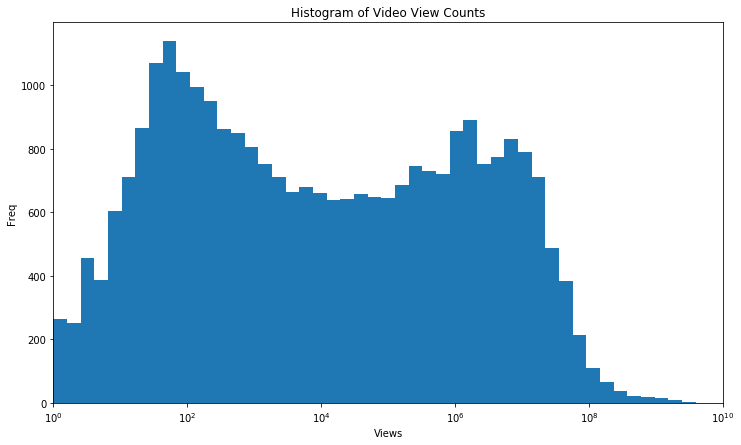

In [14]:
# Plot a histogram of the view counts
plt.figure(figsize=(12,7))
n,bins,patches = plt.hist(df_allvideos_unique['viewCount'], bins=np.logspace(0, 10, 50))
ax = plt.gca()
ax.set_xscale('log')
ax.set_title('Histogram of Video View Counts')
ax.set_xlabel('Views')
ax.set_ylabel('Freq')
ax.set_xlim([1e0, 1e10]);

- **View count distribution is bimodal** as a result of the **two different sampling processes** I employed - one using proper English words from the NLTK webtext corpus and taking those with the highest view counts (accounts for peak on the right), and the second using 4-character random strings matching the video ID format for YouTube videos in order to retrieve truly random videos (these generally have much lower view counts and therefore account for the peak on the left)

- I am **less interested in videos with midrange view counts** so will proceed to the learning phase and try to distinguish the high from low view count videos

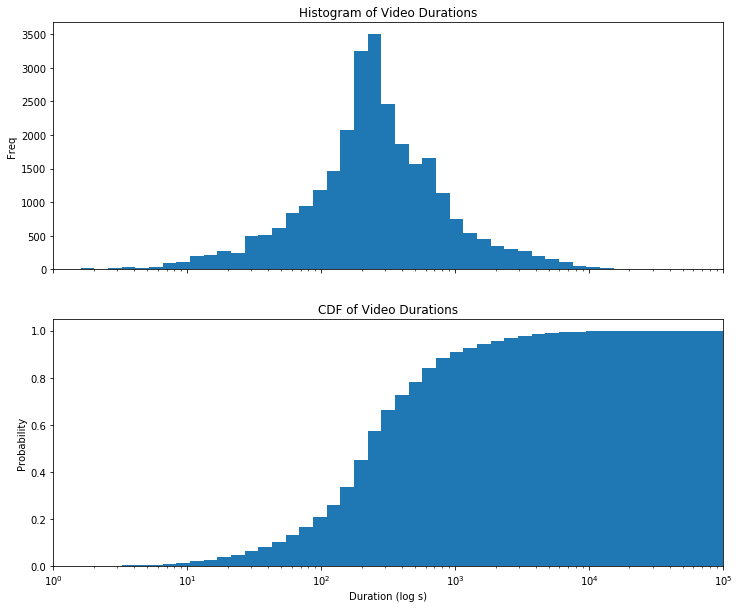

In [15]:
# Have a look at the distribution of video durations to understand how to best scale it
f, axarr = plt.subplots(2, sharex=True, figsize=(12,10))
axarr[0].hist(df_allvideos_unique['duration'], bins=np.logspace(0, 5, 50))
axarr[0].set_xscale('log')
axarr[0].set_title('Histogram of Video Durations')
axarr[0].set_ylabel('Freq')
axarr[0].set_xlim([1e0, 1e5]);

axarr[1].hist(df_allvideos_unique['duration'], bins=np.logspace(0, 5, 50), cumulative=True, normed=True);
axarr[1].set_title('CDF of Video Durations')
axarr[1].set_xlabel('Duration (log s)')
axarr[1].set_ylabel('Probability');

- **Video duration** seems to follow a **lognormal distribution**.  For learning, I will therefore scale this by taking the log of the values and using a **StandardScaler** to center them around zero

- Next let's look at the **title and desciption field lengths** to determine how to best scale/vectorize them for learning:

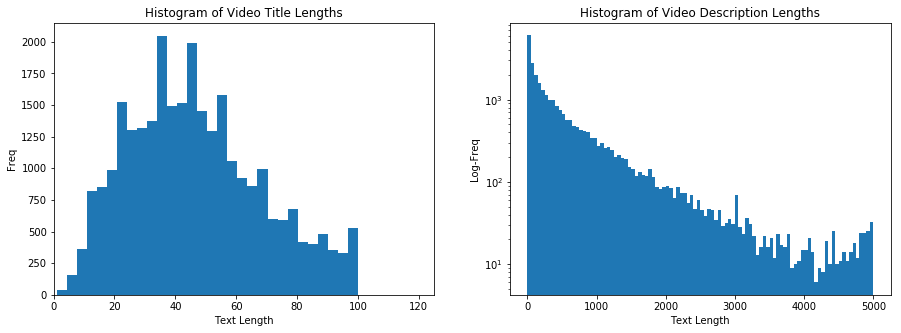

In [16]:
# Look at histogram of title/description text lengths
titlelengths = df_allvideos_unique.title.map(lambda title: len(title))
desclengths = df_allvideos_unique.description.map(lambda desc: len(desc))

fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
axarr[0].hist(titlelengths, bins=30)
axarr[0].set_xlabel('Text Length')
axarr[0].set_ylabel('Freq')
axarr[0].set_title('Histogram of Video Title Lengths')
axarr[0].set_xlim([0, 125])
axarr[1].hist(desclengths, bins=100);
axarr[1].set_xlabel('Text Length')
axarr[1].set_ylabel('Log-Freq')
axarr[1].set_title('Histogram of Video Description Lengths')
axarr[1].set_yscale('log')

From the plots:
- Video titles are limited to 100 characters
- Video descriptions are limited to 5000 characters and follow an exponential distribution (approximately linear on a log-y scale)

I will therefore use a simple **CountVectorizer for Title** and a **TfIdfVectorizer for Description** since the descriptions are a fair bit longer

### Bivariate Analysis
- Since most of the data used to predict view counts is text, only **video duration vs. view count** can really be considered here for scatter plotting
- Out of interest, I will also look at a scatter of the video **like count vs. view count** though the **like counts cannot be used for machine learning** since the video like count is not known at the time of video publishing and this would cause **data leakage**

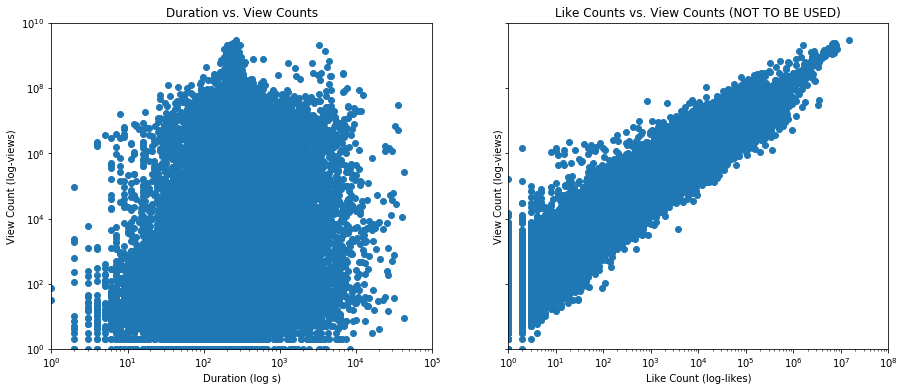

In [17]:
# Scatter plot of video duration vs. view counts
fig, axarr = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
axarr[0].scatter(df_allvideos_unique['duration'], df_allvideos_unique['viewCount'])
axarr[0].set_xlabel('Duration (log s)')
axarr[0].set_ylabel('View Count (log-views)')
axarr[0].set_title('Duration vs. View Counts')
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[0].set_xlim([1e0, 1e5])
axarr[0].set_ylim([1e0, 1e10])
axarr[1].scatter(df_allvideos_unique['likeCount'], df_allvideos_unique['viewCount'])
axarr[1].set_xlabel('Like Count (log-likes)')
axarr[1].set_ylabel('View Count (log-views)')
axarr[1].set_title('Like Counts vs. View Counts (NOT TO BE USED)')
axarr[1].set_xscale('log')
axarr[1].set_xlim([1e0, 1e8]);

- Video duration has no obvious correlation to view count
- **Like count is highly correlated to view count** though again, this **cannot be used for machine learning** since this would constitute data leakage

## Check thumbnail labeling accuracy
Finally, let's check a random sample of the thumbnail labels returned by the Google Cloud Vision API for accuracy and to determine if we need to set our own cutoff for the returned confidence score for each tag.  Confidence scores returned by the Cloud Vision API range from **0.0 (no confidence)** to **1.0 (very confident)**.

In [30]:
import operator 

# Slice the dataframe with some random values
dfThumbnailCheck = df_allvideos_unique.iloc[np.random.randint(0, len(df_allvideos_unique), 10)].loc[:, ['thumbnailUrl', 'thumbnailLabels']]

# Prepare an HTML table showing the thumbnail image alongside its tags
html = "<table><thead><tr><th>Thumbnail</th><th>Tag: Score</th></tr></thead><tbody>"
for i in range(len(dfThumbnailCheck)):
    taghtml = ""
    sortedtags = sorted(dfThumbnailCheck.iloc[i].loc['thumbnailLabels'].items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sortedtags: taghtml += "<strong>" + k + "</strong>: {:0.3f}<br/>".format(v)
    html += "<tr><td><a target='_blank' href='https://www.youtube.com/watch?v=" + dfThumbnailCheck.iloc[i].name + "'><img src='" + dfThumbnailCheck.iloc[i].loc['thumbnailUrl'] + "'/></a></td><td>" + taghtml + "</td></tr>"

html += "</tbody></table>"
display(HTML(html))

Thumbnail,Tag: Score
,finger: 0.728knitting: 0.645crochet: 0.635thread: 0.610nail: 0.583
,face: 0.965eyebrow: 0.961nose: 0.919cheek: 0.915human hair color: 0.909chin: 0.908blond: 0.905forehead: 0.881beauty: 0.867head: 0.860
,headgear: 0.814product: 0.703cap: 0.686cool: 0.680
,speech: 0.716profession: 0.644speaker: 0.621professional: 0.557public speaking: 0.505
,skin: 0.923beauty: 0.887blond: 0.764girl: 0.671advertising: 0.648long hair: 0.596media: 0.595product: 0.567font: 0.548public relations: 0.532
,sky: 0.909atmosphere: 0.873sun: 0.852daytime: 0.831heat: 0.828sunrise: 0.801morning: 0.764phenomenon: 0.755sunlight: 0.721afterglow: 0.677
,mode of transport: 0.875street: 0.716pedestrian: 0.642recreation: 0.623product: 0.573
,imam: 0.950profession: 0.868ulama: 0.787mufti: 0.652photo caption: 0.579font: 0.542public speaking: 0.533religion: 0.521
,ecosystem: 0.891orange: 0.873grass: 0.830organism: 0.767biome: 0.724pattern: 0.543
,text: 0.901black and white: 0.746font: 0.694darkness: 0.657brand: 0.632advertising: 0.584computer wallpaper: 0.573logo: 0.543monochrome: 0.540


**The labels from the computer vision API are surprisingly good!**  From what I can tell, only scores > 0.5 were sent back and the labels assigned for scores higher than this value seem to be pretty accurate so I will not bother to implement my own cutoff score.  

### Filter unneeded columns
- I will be using the **Title, Description, Tags, Duration, Category and ThumbnailLabels fields for learning** as this information is what is available when videos are first published.  Using any of the timestamp fields or the like/dislike/comment counts would constitute **data leakage** since these quantities are not known at the time of a video being first published

**Filter out the unneeded columns** and proceed to pre-processing step:

In [18]:
df_videos = df_allvideos_unique[['title', 'description', 'duration', 'categoryId', 'tags', 'thumbnailLabels', 'viewCount']]

In [19]:
# Store cleaned DataFrame before preprocessing and model building
%store df_allvideos_unique
%store df_videos

Stored 'df_allvideos_unique' (DataFrame)
Stored 'df_videos' (DataFrame)


In [197]:
%store -r df_allvideos_unique
%store -r df_videos

## Preprocessing
The fields will be pre-processed as follows:
- **CategoryIds** will be **one-hot encoded**
- **Titles, Tags and ThumbnailLabels** fields will use a basic **CountVectorizer** with stop words removed since these fields are either short or do not contain full sentences
- **Descriptions** will use a **TfIdfVectorizer** since descriptions can be more lengthy
- **Durations** and **ViewCount** will be scaled by its base10 logarithm to keep long videos and those with high view counts within a reasonable range of aprox. 0 to 10

I will reserve **10% of data (~2000 samples) as a test set** and use the remainder as train/dev sets using **ShuffleSplit for cross validation**

In [234]:
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
re_word = re.compile(r'\b[a-z]+\b', re.I)

# Removes punctuation and lowercases text fields
def stem_and_remove_punctuation(text):
    return ' '.join([stemmer.stem(w) for w in re_word.findall(text)])

def preprocess_dataset(df_videodata, log_fields=['viewCount', 'duration'], text_fields=['title', 'description', 'tags', 'thumbnailLabels'], one_hot_fields=['categoryId'], pass_through_fields=None):
    assert isinstance(df_videodata, pd.DataFrame) and isinstance(log_fields, list) and isinstance(text_fields, list)
    df_videos_cpy = df_videodata.copy()

    # Take the base 10 log of the view count and duration fields so the data is spaced out linearly (easier for learning)
    if isinstance(log_fields, list):
        for fieldname in log_fields:
            df_videos_cpy[fieldname + '_log'] = np.log10(df_videos_cpy[fieldname].apply(lambda val: max(val, 1)))

    # Pre-process text fields for vectorization (remove punctuation and convert to lower case)
    if isinstance(text_fields, list):
        for fieldname in text_fields:
            df_videos_cpy[fieldname + '_clean'] = df_videos_cpy.loc[:,fieldname].apply(lambda content: stem_and_remove_punctuation(" ".join(content) if isinstance(content, list) else (" ".join([label[0] for label in content.items()]) if isinstance(content, dict) else content)))

    # Remove unneeded columns
    df_videos_cpy = df_videos_cpy[[name + '_log' for name in log_fields] + [name + '_clean' for name in text_fields] + (pass_through_fields if isinstance(pass_through_fields, list) else []) + one_hot_fields]
            
    # Convert fields for one-hot encoding
    if isinstance(one_hot_fields, list):
        for fieldname in one_hot_fields:
            df_videos_cpy = pd.get_dummies(df_videos_cpy, columns=one_hot_fields)

    # Return pre-processed result
    return df_videos_cpy

# Pre-process the dataset and view some random records as a sanity check
df_preprocessed = preprocess_dataset(df_videos)

index = np.random.randint(0, len(df_preprocessed))
df_preprocessed.iloc[index:index+10]

,viewCount_log,duration_log,title_clean,description_clean,tags_clean,thumbnailLabels_clean,categoryId_1,categoryId_10,categoryId_15,categoryId_17,...,categoryId_23,categoryId_24,categoryId_25,categoryId_26,categoryId_27,categoryId_28,categoryId_29,categoryId_30,categoryId_43,categoryId_44
id,,,,,,,,,,,,,,,,,,,,,
rKfUeHp2IFM,0.0,0.000000,tempest s legaci by nicol peeler,click http bit com free download or read ebook...,,product smartphon electron devic gadget portab...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
uonF-8SH6WQ,0.0,2.469822,roblox prison life hack roblox hack not patch,roblox hack hat roblox hack with download welc...,roblox hack download roblox hack bypass roblox...,display advertis media display devic multimedi...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a6nb-Cn0y54,0.0,1.568202,materi handbook handbook,,,websit product text brand graphic design adver...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aqxj-EfK9F8,0.0,0.000000,rahadika satya live stream,,,shoulder plaid outerwear neckti pattern tartan...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pjNh-hZ83fA,0.0,3.755570,,,,stock photographi phenomenon screenshot sky ex...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BXQX-QAgZCk,0.0,2.827369,,ahm al ajmi tawfiq sayegh abdul rahman al suda...,,text plant font organ,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lfbW05-9vfM,0.0,2.146128,shadow fight titan new trait setup dps surviv,hello peopl i am use camscann a mobil scanner ...,game cheat tip walkthrough music unlimit money...,text brand comput wallpap graphic logo font,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VP0T-BaaWKM,0.0,1.633468,mts christma day at leo s hous,,,product interact play fun girl event,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pBB-s8-w7lw,0.0,2.238046,may,,,dark song electron devic midnight snapshot nig...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train/Test Split
- Reserve **10% of data for testing**, uniformly distributed across the dataset
- Cross-validation (hyperparameter tuning) will be performed using a shuffled, k-fold strategy on the training set

In [235]:
from sklearn.model_selection import train_test_split

# Split up dataframe into train/test sets
df_train, df_test = train_test_split(df_preprocessed, test_size=0.1, random_state=42)

print(len(df_train), len(df_test))

25485 2832


- Do a quick check to verify that the **view count distributions for the training and test sets are the same**

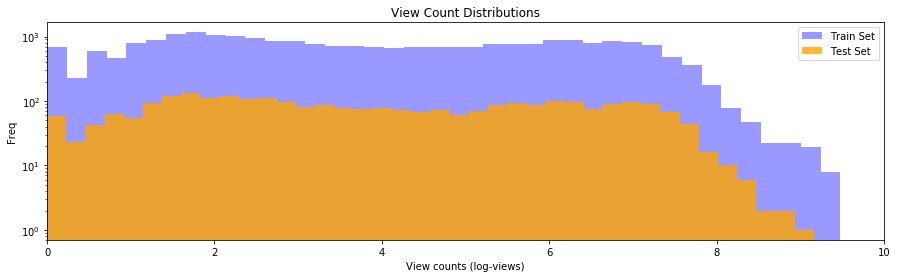

In [236]:
# Quickly check the histogram of the view counts in the test set to ensure they are distributed similarly to the overall data
#plt.set_cmap('viridis')
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.hist(df_train['viewCount_log'], bins=40, label='Train Set', alpha=0.4, color='blue')
plt.hist(df_test['viewCount_log'], bins=40, label='Test Set', alpha=.8, color='orange')
ax.set_xlabel('View counts (log-views)')
ax.set_ylabel('Freq')
ax.set_title('View Count Distributions')
ax.set_yscale('log')
ax.set_xlim([0, 10])
plt.legend();

### Prepare Matrices
- Generate matrices for machine learning model by vectorizing text fields and performing one-hot encoding, as appropriate

In [237]:
# Function to vectorize text fields using either a word count or Tf-Idf approach
def vectorize_text(df, field_name, vectorizer_type='count', **vect_kwargs):
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    assert vectorizer_type in ['count', 'tfidf'], "vectorizer_type must be either 'count' or 'tfidf'"
    assert isinstance(df, pd.DataFrame) and isinstance(field_name, str) and len(field_name) > 0

    # Initialize the appropriate text vectorizer
    vectorizer = CountVectorizer(**vect_kwargs) if vectorizer_type == 'count' else TfidfVectorizer(**vect_kwargs)
    
    # Vectorize the input text and return its vectorizer and transformed matrix result
    return (vectorizer, vectorizer.fit_transform(df[field_name]))

def get_model_matrices(df, vectorizer_dict=None, X_scaler=None, ngram_range=(1,2), text_count_fields=['title_clean', 'tags_clean', 'thumbnailLabels_clean'], \
                       text_tfidf_fields=['description_clean'], pass_through_fields=['duration_log'], \
                       output_field='viewCount_log', max_count_features=500, max_tfidf_features=1000):
    
    from collections import OrderedDict
    from scipy.sparse import csr_matrix
    from sklearn.preprocessing import MaxAbsScaler, StandardScaler
    
    # Track the boundaries of each individual field whose columns will be put into the X matrix for training (needed for model interpretability)
    # Begin with the set of pass_through_fields that will only be one column each in X
    X_passthrough = df[pass_through_fields].as_matrix()
    columncount = len(pass_through_fields)
    field_boundaries = OrderedDict(zip(pass_through_fields, zip(range(columncount), range(1, columncount + 1))))
    
    # Initialize result X matrix by stacking each generated matrix horizontally
    X = csr_matrix(X_passthrough)
    
    # Text fields that are word count vectorized
    vectorizers = vectorizer_dict if isinstance(vectorizer_dict, OrderedDict) else OrderedDict()
    for fieldname in (text_count_fields + text_tfidf_fields):
        if fieldname in vectorizers.keys():
            vectorizer = vectorizers[fieldname]
            X_vectorized = vectorizer.transform(df[fieldname])
        else:
            vectorizer, X_vectorized = vectorize_text(df, fieldname, vectorizer_type=('tfidf' if fieldname in text_tfidf_fields else 'count'), \
                       strip_accents='unicode', analyzer='word', ngram_range=ngram_range, stop_words='english', max_df=0.5, min_df=3, max_features=(max_tfidf_features if fieldname in text_tfidf_fields else max_count_features))
            # Track the text vectorizers for model interpretability later on
            vectorizers[fieldname] = vectorizer
        
        field_boundaries[fieldname] = (columncount, columncount + len(vectorizer.vocabulary_))
        columncount += len(vectorizer.vocabulary_)
        # Append vectorized text data onto overall X matrix
        X = sparse.hstack([X, X_vectorized])
    
    # Scale the columns of the matrix for better learning
    scaler = X_scaler if not X_scaler is None else MaxAbsScaler(copy=False).fit(X)
    X_scaled = scaler.transform(X)
    
    #X = X.toarray()
    #scaler = X_scaler if not X_scaler is None else StandardScaler(copy=False).fit(X)
    #X_scaled = scaler.transform(X)
    
    # Target matrix
    y = df[output_field].as_matrix().reshape(-1,1)
    
    # Return the result matrices as well as the boundaries for each field in the model and the vectorizers used
    # to transform each text field (required for model interpretability)
    return (X_scaled, y, field_boundaries, vectorizers, scaler)

In [238]:
from sys import getsizeof

# Create the training matrices, retaining the column boundaries for model interpretation
pass_through_fields = ['duration_log'] + [colname for colname in df_train.columns if colname.startswith('categoryId')]
#text_tfidf_fields = ['title_clean', 'description_clean', 'tags_clean', 'thumbnailLabels_clean']
ngram_range=(1,2)

X_train, y_train, X_boundaries, vectorizers, scaler = get_model_matrices(df_train, ngram_range=ngram_range, pass_through_fields=pass_through_fields)

print("# of samples, m = {0}\n# of features, n = {1}".format(X_train.shape[0], X_train.shape[1]))
if hasattr(X_train, 'nnz'): print("\nX_train matrix sparsity = {0:,d} of {1:,d} fields populated ({2:.3f}%)".format(X_train.nnz, (X_train.shape[0] * X_train.shape[1]), (float(X_train.nnz * 100) / (X_train.shape[0] * X_train.shape[1]))))
print("X_train size: {0:,d} bytes".format(getsizeof(X_train) if not hasattr(X_train, 'nbytes') else X_train.nbytes))
print("\nField boundaries:\n{0}".format("\n".join([str(item) for item in X_boundaries.items()])))
print("\nVectorizers created:\n{0}".format("\n".join([str(item) for item in vectorizers.items()])))

# of samples, m = 25485
# of features, n = 2519

X_train matrix sparsity = 1,049,350 of 64,196,715 fields populated (1.635%)
X_train size: 56 bytes

Field boundaries:
('duration_log', (0, 1))
('categoryId_1', (1, 2))
('categoryId_10', (2, 3))
('categoryId_15', (3, 4))
('categoryId_17', (4, 5))
('categoryId_19', (5, 6))
('categoryId_2', (6, 7))
('categoryId_20', (7, 8))
('categoryId_22', (8, 9))
('categoryId_23', (9, 10))
('categoryId_24', (10, 11))
('categoryId_25', (11, 12))
('categoryId_26', (12, 13))
('categoryId_27', (13, 14))
('categoryId_28', (14, 15))
('categoryId_29', (15, 16))
('categoryId_30', (16, 17))
('categoryId_43', (17, 18))
('categoryId_44', (18, 19))
('title_clean', (19, 519))
('tags_clean', (519, 1019))
('thumbnailLabels_clean', (1019, 1519))
('description_clean', (1519, 2519))

Vectorizers created:
('title_clean', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowe

In [239]:
# Call the same function to get the test matrices, but pass in the existing vectorizers to transform the test data the same way
X_test, y_test, _, _, _ = get_model_matrices(df_test, ngram_range=ngram_range, pass_through_fields=pass_through_fields, vectorizer_dict=vectorizers, X_scaler=scaler)

In [240]:
print("X_train shape = {0}".format(X_train.shape))
print("X_test shape = {0}".format(X_test.shape))

X_train shape = (25485, 2519)
X_test shape = (2832, 2519)


- From the matrix shapes, we have **n = 2519 total features** 
- The **Title, Tags and ThumbnailLabels fields** were limited to a vocabulary of **500 words** while the **Description field** was limited to **1000 words**.  This was done to reduce overfitting and improve model training time
- The other **19 feature columns** are for the **video duration** and **one-hot encoded category ID fields**

In [241]:
## Store matrices for machine learning
%store X_train
%store y_train
%store X_test
%store y_test
%store X_boundaries
%store vectorizers
%store scaler

Stored 'X_train' (csr_matrix)
Stored 'y_train' (ndarray)
Stored 'X_test' (csr_matrix)
Stored 'y_test' (ndarray)
Stored 'X_boundaries' (OrderedDict)
Stored 'vectorizers' (OrderedDict)
Stored 'scaler' (MaxAbsScaler)


In [19]:
## Restore matrices for machine learning
%store -r X_train
%store -r y_train
%store -r X_test
%store -r y_test
%store -r X_boundaries
%store -r vectorizers
%store -r scaler

## Build Model
- I originally trained a model using **full vocabularies** for each of the text fields and this **resulted in nearly n = 150k features** and thus I chose a Lasso linear regression approach via **LassoCV()** to promote model sparsity  
- However, **working with such a large model was unwieldly** and I found I could achieve **comparable performance by limiting the field vocabularies to 500 and 1000 words** for non-Description and Description fields, respectively  
- I therefore tried using a **Support Vector Regressor** with **linear kernel** (i.e. the **LinearSVR()** class) on the smaller model and this reduced training time to **less than 1s** so it allowed me to iterate and tune my hyperparameters much more quickly
- Finally, I performed **cross-validation** using **RandomizedSearchCV()** to quickly hone-in on the optimal value of the **C parameter** for the **LinearSVR()** by calculating the **$R^2$ coefficient of determination** on the **test set**

In [242]:
from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.svm import LinearSVR, SVR

class youtube_model():
    def __init__(self, X_train, y_train, X_test, y_test, vectorizers, X_boundaries, random_state=42):
        self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test
        self.vectorizers, self.X_boundaries, self.random_state = vectorizers, X_boundaries, random_state
    
    def print_scores(self, estimator):
        print("Training set R2 score: {0}".format(estimator.score(self.X_train, self.y_train)))
        if not X_test is None and not y_test is None: print("Test set R2 score: {0}".format(estimator.score(self.X_test, self.y_test)))
    
    def set_cv_result(self, cv_result, print_results=True):
        self.cv_result = cv_result
        self.is_cross_validated = True
        if print_results: self.print_cv_result()
    
    def display_lasso_cv_graph(self, lasso_cv):
        fig = plt.figure(figsize=(15, 6))
        df_results = pd.DataFrame(lasso_cv.mse_path_.T, index=['Split #{0}'.format(i+1) for i in range(lasso_cv.mse_path_.shape[1])], \
                              columns=['{0:.1e}'.format(lasso_cv.alphas_[i]) for i in range(len(lasso_cv.alphas_))])
        ax = fig.gca()
        df_results.plot(ax=ax)
        ax.legend(loc='upper right', title='Lambda')
        ax.set_title('Cross-Validation MSE for each Lambda')
        ax.set_ylabel('Mean-Squared Error (MSE)')

    def print_cv_result(self):
        assert self.is_cross_validated, "Cross-validation has not yet been performed"
        self.print_scores(self.cv_result)
        if isinstance(self.cv_result, LassoCV):
            print("\nFinal alpha: {0}".format(self.cv_result.alpha_))
            print("Intercept: {0}".format(self.cv_result.intercept_))
            print("# of non-zero coefficients: {0}".format(np.count_nonzero(self.cv_result.coef_)))
            #print("MSE path: {0}".format(self.cv_result.mse_path_))
            print("Alphas: {0}".format(self.cv_result.alphas_))
            self.display_lasso_cv_graph(self.cv_result)
            
        elif isinstance(self.cv_result, RandomizedSearchCV):
            display(pd.DataFrame(self.cv_result.cv_results_))
            if self.cv_result.refit:
                print("Best estimator: {0}".format(self.cv_result.best_estimator_))
                print("Best avg. score for all splits: {0}".format(self.cv_result.best_score_))
                print("Best params: {0}".format(self.cv_result.best_params_))
            print("Scorer: {0}".format(self.cv_result.scorer_))
            print("Total splits: {0}".format(self.cv_result.n_splits_))
        
        self.print_best_coefs()
    
    def get_field_coefficients(self):
        assert self.is_cross_validated, "Cross-validation has not yet been performed"
        best_svr = self.cv_result if isinstance(self.cv_result, LassoCV) else self.cv_result.best_estimator_
        
        # Expand the field boundaries dictionary into a full list of fieldnames, vocabulary and model coefficients for each entry
        fieldnames, vocab_words, coefficients = [], [], []
        for fieldname in self.X_boundaries.keys():
            fieldlen = self.X_boundaries[fieldname][1] - self.X_boundaries[fieldname][0]
            vectorizer = vectorizers[fieldname] if fieldname in vectorizers.keys() else None
            fieldnames += [fieldname.replace('_clean', '').replace('_log', '')]*fieldlen
            vocab_words += ['']*fieldlen if vectorizer is None else np.array(list(vectorizer.vocabulary_.keys()))[list(np.array(list(vectorizer.vocabulary_.values())).argsort())].tolist()
        return pd.DataFrame({'Field': fieldnames, 'Text': vocab_words, 'Coefficient': best_svr.coef_}, columns=['Field', 'Text', 'Coefficient'])
        
    def print_best_coefs(self, k=10):
        # Get the model coefficients as a DataFrame
        df_fields = self.get_field_coefficients()
        df_fields.sort_values('Coefficient', ascending=False, inplace=True)
        print("\nTop {0} Coefficients:".format(k))
        display(df_fields[:k])
        print("\nBottom {0} Coefficients:".format(k))
        display(df_fields[:-k-1:-1])
    
    def get_shuffle_cv(self, n_splits, test_size=0.1):
        return ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=self.random_state)
        
    def run_lasso_cv(self, param_dict, n_splits=10, max_iter=30, n_jobs=4):
        shuffle_cv = self.get_shuffle_cv(n_splits=n_splits)
        lasso_cv = LassoCV(n_alphas=1, alphas=param_dict['alpha'], max_iter=max_iter, cv=shuffle_cv, n_jobs=n_jobs, random_state=self.random_state)
        #lasso = Lasso(alpha=0.001, max_iter=1000, random_state=self.random_state)
        lasso_cv.fit(self.X_train, np.ravel(self.y_train))
        self.set_cv_result(lasso_cv)
    
    def run_svr_cv(self, param_dict, n_splits=10, max_iter=30, n_jobs=4):
        shuffle_cv = self.get_shuffle_cv(n_splits=n_splits)
        svr = LinearSVR(epsilon=0.0, tol=0.0001, max_iter=max_iter)
        #svr = SVR(epsilon=0.0, tol=0.0001, max_iter=max_iter)
        search_cv = RandomizedSearchCV(svr, param_distributions=param_dict, cv=shuffle_cv, n_iter=len(list(param_dict.items())[0][1]), scoring='r2', n_jobs=n_jobs, random_state=self.random_state, refit=True, return_train_score=True)
        search_cv.fit(self.X_train, np.ravel(self.y_train))
        self.set_cv_result(search_cv, print_results=False)

In [243]:
# Initialize the model
model = youtube_model(X_train, y_train, X_test, y_test, vectorizers, X_boundaries)

In [244]:
# Perform cross-validation for C parameter
#%%timeit -r 1 -n 1
import time
start_time = time.time()

params = {}
params['C'] = np.logspace(-3, 0, 10)
#params['C'] = np.logspace(-1.5, -0.5, 10)
#params['C'] = np.linspace(0.09, 0.15, 20)
#params['C'] = np.linspace(0.12, 0.12, 1)

model.run_svr_cv(param_dict=params, n_splits=4, max_iter=30, n_jobs=4)

elapsed_time = time.time() - start_time
print("Elapsed time: {0:.3f}s".format(elapsed_time))

Elapsed time: 5.070s


## Results

- Best **Training and Test set $R^2$ scores** were **0.53 and 0.47**, respectively, meaning that about half of the variance is still unexplained though this is still a fair bit better than a mean predictor
- The **results of the cross-validation** run found the optimal value of **C=0.1** and the best model fields and coefficients as shown below

In [245]:
model.print_cv_result()

Training set R2 score: 0.5264969388151792
Test set R2 score: 0.47528235689731113


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.085255,0.00125,0.281216,0.275838,0.001,{'C': 0.001},10,0.272457,0.276822,0.297493,0.275880,0.293606,0.272733,0.261309,0.277916,0.003767,4.330157e-04,0.014929,0.001932
1,0.194261,0.00175,0.355831,0.350169,0.00215443,{'C': 0.0021544346900318843},9,0.348134,0.350910,0.365815,0.350560,0.374125,0.347127,0.335252,0.352077,0.098842,4.330502e-04,0.015142,0.001844
2,0.125757,0.00100,0.397583,0.395163,0.00464159,{'C': 0.004641588833612777},8,0.390888,0.395518,0.403762,0.395872,0.419672,0.392455,0.376010,0.396808,0.001785,1.685874e-07,0.016096,0.001633
3,0.164509,0.00100,0.431301,0.435597,0.01,{'C': 0.01},7,0.425488,0.435986,0.434387,0.436037,0.454676,0.433522,0.410653,0.436842,0.032869,1.032383e-07,0.015938,0.001245
4,0.218263,0.00150,0.460332,0.474221,0.0215443,{'C': 0.021544346900318832},5,0.454997,0.474304,0.460804,0.475427,0.481668,0.472245,0.443857,0.474906,0.053517,5.000234e-04,0.013742,0.001208
5,0.187761,0.00150,0.478983,0.505077,0.0464159,{'C': 0.046415888336127774},3,0.475418,0.504952,0.477469,0.506401,0.495563,0.503659,0.467483,0.505295,0.019805,5.000830e-04,0.010273,0.000978
6,0.278266,0.00175,0.486357,0.526648,0.1,{'C': 0.1},1,0.483683,0.526659,0.483501,0.527692,0.500207,0.525506,0.478035,0.526735,0.033441,4.330846e-04,0.008312,0.000775
7,0.314268,0.00150,0.483013,0.538221,0.215443,{'C': 0.21544346900318823},2,0.480369,0.538889,0.479536,0.538946,0.494844,0.536545,0.477304,0.538503,0.018966,5.000234e-04,0.006922,0.000982
8,0.401023,0.00150,0.470370,0.541654,0.464159,{'C': 0.46415888336127775},4,0.472505,0.541322,0.463040,0.542604,0.480728,0.540356,0.465209,0.542334,0.059510,4.999042e-04,0.006932,0.000889
9,0.426275,0.00125,0.447092,0.533484,1,{'C': 1.0},6,0.457143,0.534419,0.435571,0.531996,0.451883,0.530990,0.443772,0.536529,0.024703,4.330846e-04,0.008181,0.002155


Best estimator: LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=30,
     random_state=None, tol=0.0001, verbose=0)
Best avg. score for all splits: 0.4863566520189861
Best params: {'C': 0.1}
Scorer: make_scorer(r2_score)
Total splits: 4

Top 10 Coefficients:


,Field,Text,Coefficient
0,duration,,2.722803
2090,description,music video,2.701575
287,title,lyric,2.115727
2007,description,licens,1.696588
1906,description,http,1.586399
2261,description,scene,1.529287
2039,description,lyric,1.430511
2146,description,perform,1.401495
1611,description,buzzfe,1.400102
2003,description,lesson,1.371704



Bottom 10 Coefficients:


,Field,Text,Coefficient
2169,description,pleas watch,-1.999521
426,title,sold,-1.593128
1567,description,auto,-1.296277
407,title,sale,-1.026111
1845,description,generat,-1.018653
1949,description,injuri,-1.014671
78,title,caus,-1.000000
665,tags,estat,-0.926819
1655,description,com channel,-0.904017
1195,thumbnailLabels,floor,-0.896516


You can see the **top 10 coefficients and bottom 10 coefficients** along with the fields + associated text they pertain to.  Aside from the video duration field, the **contents of the description field appears to be the best predictor of video view counts**, particularly with words pertaining to music or social media

Let's examine the model coefficients in more detail by **creating wordclouds for each of the text fields** in the model:

In [246]:
# Retrieve all field coefficients from the model for more detailed processing
df_coefs = model.get_field_coefficients()

In [338]:
from wordcloud import WordCloud
textfields = ['title', 'description', 'tags', 'thumbnailLabels']
textcolors = ['#6666ff', '#ff6666', '#66ff66', '#000000']

def get_word_cloud(df_coef, fieldname, k, coef_type='best'):
    # Filter the dataframe to only retain words in the designated field name
    if not isinstance(fieldname, list): fieldname = [fieldname]
    df_fieldwords = df_coef[df_coef['Field'].isin(fieldname)].sort_values('Coefficient', ascending=False)
    df_fieldwords.drop_duplicates(subset=['Text'], inplace=True)
    
    # Select the best or worst k coefficients and terms
    if coef_type == 'best': df_fieldwords = df_fieldwords[:k]
    else: df_fieldwords = df_fieldwords[:-k-1:-1]
        
    # Create a dictionary to map words from each field to a different colour
    color_dict = {}
    for i in range(len(df_fieldwords)): color_dict[df_fieldwords.iloc[i].loc['Text']] = textcolors[textfields.index(df_fieldwords.iloc[i].loc['Field'])]
    def get_color(word, font_size, position, orientation, font_path, random_state):
        return color_dict[word]
    
    # Generate the word cloud passing the model coefficient as the relative frequency value
    word_dict = dict(zip(list(df_fieldwords['Text']), list(df_fieldwords['Coefficient'])))
    return WordCloud(relative_scaling=1, scale=1.5, color_func=get_color, background_color='white').generate_from_frequencies(word_dict)

def display_combined_word_cloud(df_coef, wordcount=80):
    plt.figure(figsize=(15,10))
    ax = plt.subplot(111)
    wordcloud = get_word_cloud(df_coef, textfields, k=wordcount)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Move the legend off of the main plot area
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=c, lw=4) for c in textcolors]
    ax.legend(custom_lines, textfields, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def display_field_word_clouds(df_coef, wordcount=40):
    plt.subplots(4, figsize=(15, 8))
    for i,fieldname in enumerate(textfields):
        wordcloud = get_word_cloud(df_coef, fieldname, k=wordcount)
        
        # Display in the grid
        plt.subplot(220 + i + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('{0}'.format(fieldname.replace("lL", "l L").title()), fontsize=16)
    plt.tight_layout()
    plt.show()

### Text Field Results
- Below is a **wordcloud of the top 80 vocabulary terms** across all text fields (Title, Description, Tags and Thumbnails) that the model predicts will lead to the **highest view counts**
- Note that due to **word stemming**, the **suffixes** of many these terms **have been removed**
- We can quickly see that **words in the Description field dominate**, however the **top word** is **'lyric'** when contained in the **Title field**
- The **thumbnail labels** returned by the Google Vision API only make up 2 of the top 100 predictors and thus are **not heavily prioritized** by the model

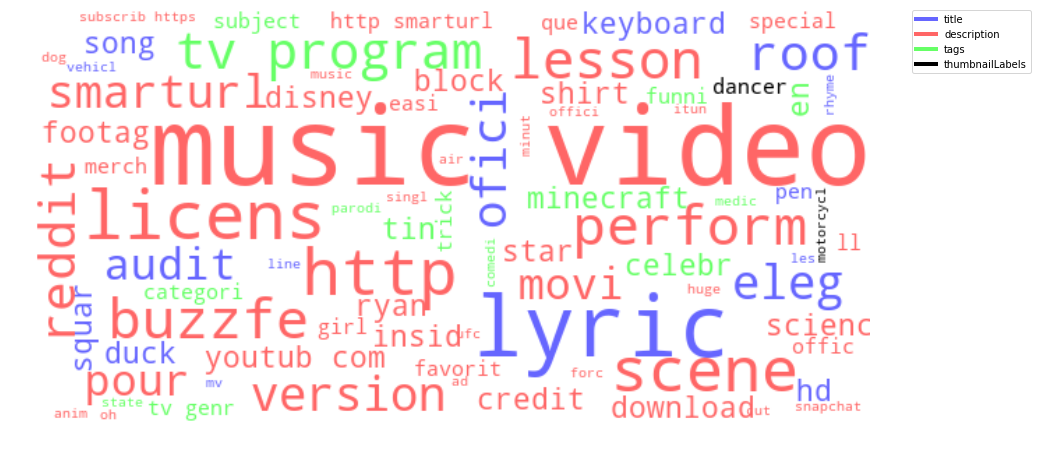

In [407]:
display_combined_word_cloud(df_coefs, wordcount=80)

- The wordcloud shows that **multimedia terms** (music video, tv program, movi) and **social media terms** (buzzfeed, reddit) tend to be used most to **predict video popularity**
- Below are word clouds showing the **top words** for each **individual text field**:

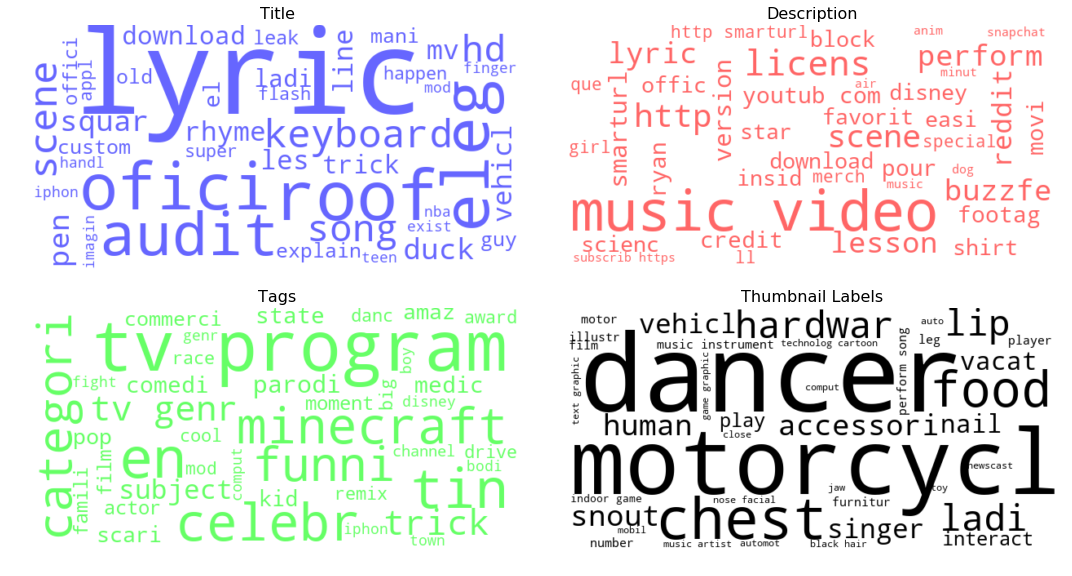

In [408]:
display_field_word_clouds(df_coefs, wordcount=40)

### Relative Importance of each Text Field
- The pie chart below shows the **fraction of top model coefficients by text field**
- The **Description field accounts for nearly 3 out of 5 top words** though this field has 2x more words in the model (n=1000) as compared to Tags and Title (n=500 each)
- **Title and Tags fields** have about **equal weight** in terms of predicting highest view counts

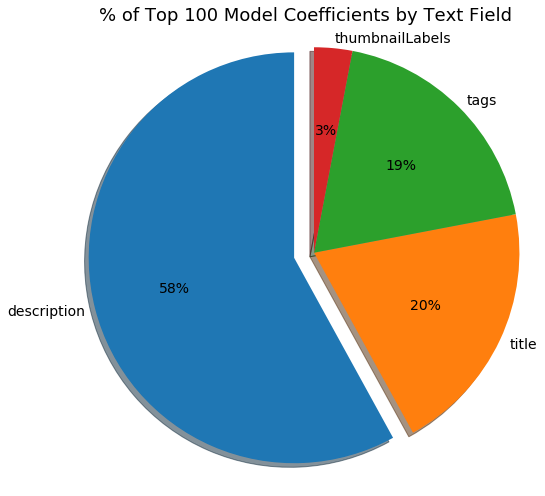

In [341]:
# Create a pie chart showing the number of the top 100 model coefficients belonging to each text field
k = 100
df_filtered = df_coefs[df_coefs['Field'].isin(textfields)].sort_values('Coefficient', ascending=False)
s_importance = df_filtered.iloc[:k].loc[:,'Field'].value_counts()
if 'thumbnailLabels' not in s_importance: s_importance['thumbnailLabels'] = 0

# Plot the pie chart
fig,ax = plt.subplots(figsize=(7,7))
ax.pie(s_importance.values, labels=s_importance.index.values, labeldistance=1.05, textprops={'fontsize': 14}, shadow=True, autopct='%1.0f%%', startangle=90, explode=[0.1,0,0,0])
ax.axis('equal')
plt.title("% of Top {0} Model Coefficients by Text Field".format(k), fontsize=18)
plt.tight_layout()
plt.show()

### Video Category Results
- The bar graph below shows **how much weight is assigned by the model to the video category** in terms of view count predictive power.  Particularly, videos in the **Shows and Music categories seem to be most popular** whereas **People & Blogs as well as Nonprofits & Activism videos tend to be least popular** in general

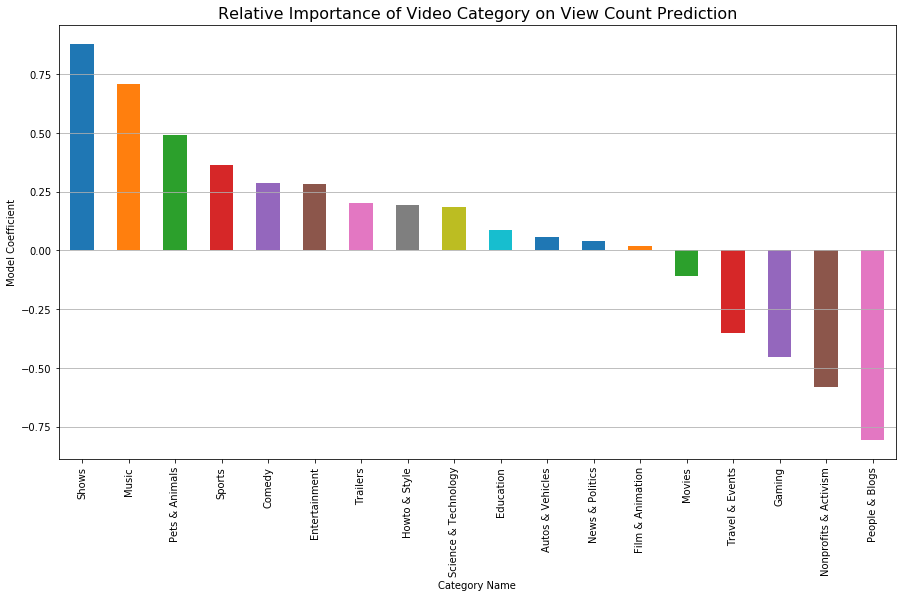

In [345]:
# Plot the coefficients for each video category
df_cats = df_coefs[df_coefs.Field.str.startswith('categoryId')].copy()
df_cats['Id'] = df_cats.apply(lambda row: row.loc['Field'][len('categoryId_'):], axis=1)
df_cats = pd.merge(df_cats, df_categories, how='left', left_on='Id', right_index=True).set_index('Id').loc[:, ['categoryName', 'Coefficient']].sort_values('Coefficient', ascending=False)

ax = df_cats.plot(x='categoryName', y='Coefficient', kind='bar', figsize=(15, 8), legend=False)
ax.set_title('Relative Importance of Video Category on View Count Prediction', fontsize=16)
ax.set_xlabel("Category Name")
ax.set_ylabel("Model Coefficient")
ax.grid(True, axis='y')
pass

## Conclusion
The **most popular videos on YouTube** are undoubtedly those related to **movies, music videos and social media** as the best fields for predicting high view counts are the **Duration field** and vocabulary in the **Description field** related to these topics. Since this particular model had an **$R^2$ score of ~0.5**, there is room for improvement, possibly by using a more sophisticated model (e.g. a neural network) or by changing the feature selection process to use a different text vectorization procedure.

**I learned a great deal** throughout this project, including the use of the YouTube and Vision **Google Cloud APIs** as well as some useful plotting tools in **matplotlib**, the **cross-validation** process in **scikit-learn** and much more!

Thank you for your interest in this work.